### Simple Perceptron
A perceptron in a linear binary classifier inspired by the simplest unit of a biological neural network, the single-cell neuron. A brief discussion of the neuronal system will add context useful in understanding its artificial counterpart.

Membrane potential describes the charge interior to the cell membrane with respect to the environment exterior. In a neuron at rest, this is equal to approximatley -70 mV (millivolts). Chemical activity at the synapse between the cell and its neighbor can trigger depolarization, an event in which the polarization of the membrane is reduced; the membrane potential thus transiently increases towards a neutral value of 0 mV. 

If the stimulating event is of sufficient magnitude, the potential will reach, and then cross, a value of -55 mV. This value is significant and known as the **threshold potential**, or threshold above which cellular behavior changes. At ≥ 55 mV, an action potential, or 'spike' in membrane potential, is triggered. This consists of a rapid increase and equally rapid decrease as measured over time. All of this occurs on a scale of about 5 ms. 

< insert graphic of action potential >

< possibly explain voltage-gated sodium channels and g-proteins > 

Okay. So what does this mean for us? Much as a biological neuron requires reception of an input of sufficient magnitude to fire, a perceptron is activated only if its own threshold is met. Inputs are received and computations are performed upon them. The final result is a signal highly analogous to the electrochemical impulse passed between cells. 

***Setup***

We'll start by clearing any existing variables and importing dependencies. 

In [96]:
%reset -f

import random, math
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

***Import and Explore Data***

We'll begin by importing our dataset. Please note that this algorithm is only suitable for linearly separable data sets, wherein a line could completely separate two classes in a binary classification problem. 

We'll be using the famous Iris set from the University of California, Irvine Machine Learning Repository. You can find it here: http://archive.ics.uci.edu/ml/datasets/Iris

Please note also that feature names are not specified in the data file; they are however listed on the set's page on the UCI site (link above). We'll write them in manually for simplicity. "Class" has been replaced with "Label" so as not to provoke confusion about Python's class keyword. 

In [97]:
df = pd.read_csv('Data/iris/iris.data', 
                 names = ['Sepal Length (cm)',
                          'Sepal Width (cm)',
                          'Petal Length (cm)',
                          'Petal Width (cm)',
                          'Label'])

df.head() # Displays first five rows for us to inspect. 

,Sepal Length (cm),Sepal Width (cm),Petal Length (cm),Petal Width (cm),Label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


I'd like to display each class name. We can use a set for this:

In [98]:
for label in set(df.Label):
    print(label)

Iris-virginica
Iris-setosa
Iris-versicolor


Let's first plot our data. We need to create a color map which will allow each class to be plotted in its own identifying color. We'll start by building a dictionary whose keys are the unique class labels above:

In [99]:
colormap = {}
colors = ['red', 'blue', 'green']

for label, color in zip(set(df.Label), colors):
    colormap[label] = color

print(colormap)

{'Iris-virginica': 'red', 'Iris-setosa': 'blue', 'Iris-versicolor': 'green'}


This color map will be passed as a parameter to our plotting function. 

<Axes: title={'center': 'Sepal Width (cm) vs. Sepal Length (cm)'}, xlabel='Sepal Length (cm)', ylabel='Sepal Width (cm)'>

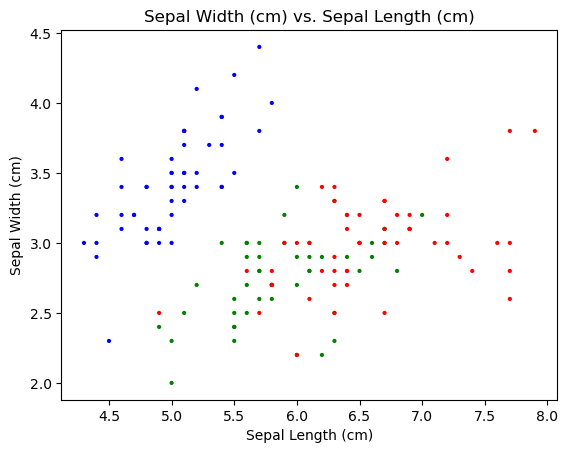

In [100]:
fig, ax = plt.subplots(facecolor = 'white')

x_name = 'Sepal Length (cm)'
y_name = 'Sepal Width (cm)'

df.plot(x = x_name,
        y = y_name,
        kind = 'scatter',
        ax = ax,
        s = 4, 
        c = [colormap.get(c, 'black') for c in df.Label],
        title = str(y_name) + ' vs. ' + str(x_name))


***Data Preparation***

We will consider only two classes from the dataset: "Iris-setosa" and "Iris-virginica" known to be linearly separable. 

By definition, this means that there exists some line describable by the equation $ y = wx_{0} + wx_{1} + ... wx_{n} $ that completely dissects and separates the red and green data points.

We will extract the data as well as corresponding features for our training inputs: "Sepal Length (cm)" and "Sepal Width (cm)". We have omitted the two other features included in this data set for simplicity. 

C:\Users\Mia\AppData\Local\Temp\ipykernel_31824\3094935024.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['Label'] = df_binary['Label'].map({'Iris-setosa': 0, 'Iris-virginica': 1})


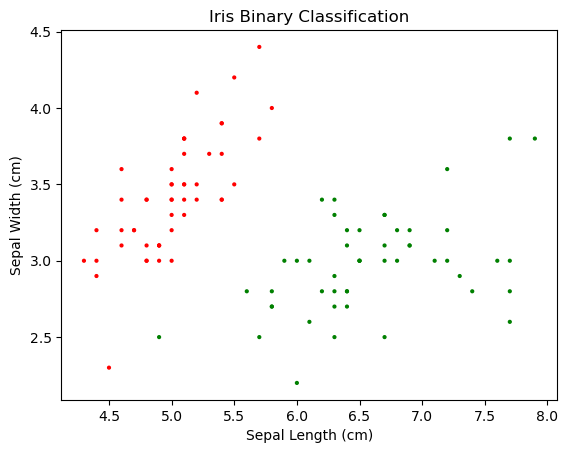

In [101]:
# Filter out only two classes for binary classification: Iris-setosa and Iris-virginica
df_binary = df[df['Label'].isin(['Iris-setosa', 'Iris-virginica'])]

# Map the class labels to binary values: Iris-setosa -> 0, Iris-virginica -> 1
df_binary['Label'] = df_binary['Label'].map({'Iris-setosa': 0, 'Iris-virginica': 1})

# Extract inputs and labels
X = df_binary[['Sepal Length (cm)', 'Sepal Width (cm)']].values
y = df_binary['Label'].values

# Plotting the binary data to visualize
fig, ax = plt.subplots(facecolor='white')
df_binary.plot(x='Sepal Length (cm)', y='Sepal Width (cm)', kind='scatter', ax=ax,
               c=df_binary['Label'].map({0: 'red', 1: 'green'}), s=4, title="Iris Binary Classification")
plt.show()


***Define Model***

The Perceptron class is a simple implementation of a binary classifier using a single-layer neural network. It is designed to classify input data into one of two possible classes (typically labeled as 0 or 1). It includes model weights (parameters) as well as key hyperparameters. 

In [102]:
class Perceptron:
    def __init__(self, num_inputs, learning_rate):
        self.weights = np.array([])
        self.learning_rate = learning_rate
        for i in range(0, num_inputs): # initialize random weights
            self.weights = np.append(self.weights, random.uniform(-1,1))
            
    def get_weights(self):
        '''
        Getter method to return weights. 

        Returns
        -------
        Numpy array
            self.weights

        '''
        return self.weights

    def train(self, inputs, label):
        '''
        Train the classifier.

        Returns
        -------
        None

        '''
        guess = self.feedforward(inputs)
        error = label - guess
        for i in range(0, len(self.weights)):
            self.weights[i] += learning_rate * error * inputs[i]

    def feedforward(self, inputs):
        '''
        Perform feedforward calculations.
        
        Parameters
        ----------
        inputs : list
            Input data. 

        Returns
        -------
        INT
            self.activate(summation): activated weighted sum of inputs; either 0 or 1. 

        '''
        summation = 0
        for i in range(0, (len(self.weights))):
            x_i = inputs[i]
            w_i = self.weights[i]
            summation += np.dot(w_i, x_i)
        return self.activate(summation)

    def activate(self, total):
        '''
        Activation using a step function; binary output will be 0 or 1.

        Parameters
        ----------
        total : float
            The sum of the linear combination of inputs and weights.

        Returns
        -------
        int
            A value of 0 if sum is greater than or equal to zero;
            a value of 1 if sum is less than zero.
        '''        
        if total >= 0:
            return 1
        if total < 0:
            return 0


***Training***

Training involves iteratively adjusting the perceptron's weights based on its predictions and the corresponding labels. This is a supervised learning process, where the model receives labeled data, makes predictions, and updates its weights to reduce the error between its predictions and the actual labels.

Phases: 

1. Initialization: random weights assigned to each input feature. These weights are used to compute the weighted sum of the inputs, which is then passed through an activation function to produce a prediction. In our example, we initialize with two of four features found in the original Iris set. 

2. Feedforward calculations: during each training iteration, the perceptron makes a prediction based on current weights and input data. The feedforward process calculates the weighted sum of the input features, and the result is passed through an activation function. 

3. Activation function: in general, determines the final output of the perceptron. Our model uses a step function, a simple binary activation function that outputs one of two values depending on whether the input meets a certain threshold. This can be represented as

$$
\text{step}(x) =
\begin{cases}
1 & \text{if } x \geq \text{threshold} \\
0 & \text{if } x < \text{threshold}
\end{cases}
$$

Where \(x\) is the input, and the function outputs either 1 or 0.

In other words, if the weighted sum is greater than or equal to zero, it outputs 1; otherwise, it outputs 0.

4. Error calculation: finds the difference between the predicted output value and the actual label. 

5. Iteration: the process repeats for each example in the set and each epoch until a stopping criterion is met. 

In this example, we'll begin with a learning rate of 0.1 and train the model for a set number of epochs.

***Hyperparameters***

**Learning rate**: controls the rate of weight adjustment at each iterative training step. Our example rate of 0.10 signifies that weights will be adjusted by 10% of the error found. Weight updates are directly proportional to the error found, and thus learning rate acts as a type of scaling factor. Typical range: 0.01 to 0.10. 

Consider: if too large, the model may overshoot an optimal solution, leading to instability in the training process. Weights may oscillate or diverge. If too small, learning will occur very slowly, requiring many iterations to converge. In some cases, an optimal solution may not be found. 

Recommendation: start with a moderate value and experiment with adjustments based on model performance and convergence speed. 

**Number of Epochs**: an epoch refers to one complete passthrough of the entire dataset. Thus, the choice of epochs signifies the number of complete training iteractions. Typical range: 10 to 1000. 

Consider: if too few, the model may not have the opportnuity to learn the correct decision boundary, leading to underfitting. If too many: overfitting may occur, especially if the dataset is small. 

Recommendation: start with a smaller number and increase if more are needed.

In [103]:
# Choose hyperparameters
learning_rate = 0.1
num_epochs = 100

# Initialize the perceptron
perceptron = Perceptron(num_inputs=2, learning_rate=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for i in range(len(X)):
        perceptron.train(X[i], y[i])

# Display model weights after training
print("Final weights after training:", perceptron.get_weights())

Final weights after training: [ 2.8773252  -4.28093345]


***Model Evaluation***

To evaluate how well the perceptron has learned, we can test it by feeding it the same inputs and comparing its predictions with the actual labels.

In [104]:
# Evaluate the perceptron by testing its predictions
correct = 0
for i in range(len(X)):
    prediction = perceptron.feedforward(X[i])
    if prediction == y[i]:
        correct += 1

accuracy = correct / len(X) * 100
print(f"Accuracy: {accuracy}%")

Accuracy: 81.0%


***Plot Decision Boundary***

To visualize the learned decision boundary, we'll plot the data points and draw the line that separates the two classes.

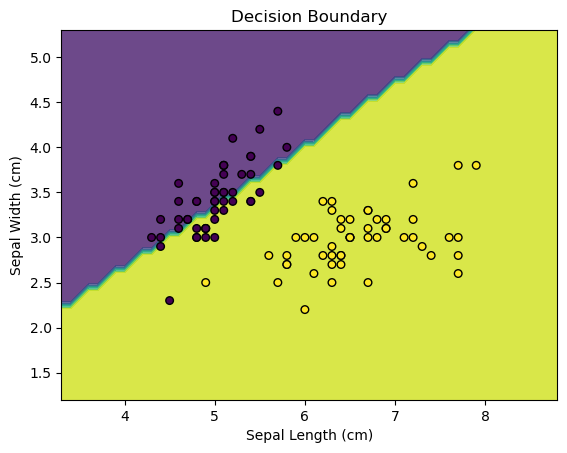

In [105]:
# Plot the decision boundary
def plot_decision_boundary(perceptron, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))

    Z = np.array([perceptron.feedforward([x, y]) for x, y in zip(xx.ravel(), yy.ravel())])
    Z = Z.reshape(xx.shape)

    fig, ax = plt.subplots()
    ax.contourf(xx, yy, Z, alpha=0.8)
    ax.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=30)
    ax.set_title("Decision Boundary")
    ax.set_xlabel("Sepal Length (cm)")
    ax.set_ylabel("Sepal Width (cm)")
    plt.show()

plot_decision_boundary(perceptron, X, y)